In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib as plt
import datetime
import time
import numpy as np
import gc

In [2]:
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

# Preprocess News Data

In [4]:
#Using 2010 to 2016 data
def process_news_data(news_data):
    print("Shape : {}".format(news_data.shape))
    news_data = news_data.drop(news_data.columns[0], axis=1)
    news_data['time'] = pd.to_datetime(news_data['time'])
    news_data['sourceTimestamp'] = pd.to_datetime(news_data['sourceTimestamp'])
    news_data['firstCreated'] = pd.to_datetime(news_data['firstCreated'])
    news_data['provider'] = news_data['provider'].astype('category')
    news_data['subjects'] = news_data['subjects'].astype('category')
    news_data['audiences'] = news_data['audiences'].astype('category')
    news_data['assetCodes'] = news_data['assetCodes'].astype('category')
    news_data['assetName'] = news_data['assetName'].astype('category')
    news_data = news_data[news_data['time'].dt.year > 2009]
    
    news_data['rel_firstMention'] = 1.0*news_data['firstMentionSentence']/news_data['sentenceCount']
    news_data['rel_SentCount'] = 1.0*news_data['sentimentWordCount']/news_data['wordCount']
    
    return news_data

In [5]:
df1 = pd.read_csv("../../DataSet/news_train1.csv")
df1 = process_news_data(df1)
df2 = pd.read_csv("../../DataSet/news_train2.csv")
df2 = process_news_data(df2)
df3 = pd.read_csv("../../DataSet/news_train3.csv")
df3 = process_news_data(df3)
df4 = pd.read_csv("../../DataSet/news_train4.csv")
df4 = process_news_data(df4)
df5 = pd.read_csv("../../DataSet/news_train5.csv")
df5 = process_news_data(df5)
df6 = pd.read_csv("../../DataSet/news_train6.csv")
df6 = process_news_data(df6)
df7 = pd.read_csv("../../DataSet/news_train7.csv")
df7 = process_news_data(df7)
df8 = pd.read_csv("../../DataSet/news_train8.csv")
df8 = process_news_data(df8)
df9 = pd.read_csv("../../DataSet/news_train9.csv")
df9 = process_news_data(df9)
df10 = pd.read_csv("../../DataSet/news_train10.csv")
df10 = process_news_data(df10)
news_data = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10])
del df1,df2,df3,df4,df5,df6,df7,df8,df9,df10
# news_data = pd.concat([df1,df2,df3,df4])

Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (1000000, 36)
Shape : (328749, 36)


In [6]:
news_data.shape

(7003399, 37)

In [7]:
news_data = news_data[pd.notnull(news_data['headline'])]
news_data.shape

(6987566, 37)

In [8]:
## Removing late report of news
news_data['news_delay'] = news_data['time'] - news_data['sourceTimestamp']
news_data = news_data[news_data.news_delay < datetime.timedelta(days=1)]
news_data['time'] = news_data['time'].dt.date
news_data.shape

(6987562, 38)

# Analysis

In [9]:
news_columns = ['time','urgency', 'assetCodes', 'assetName', 'relevance', 'sentimentClass','rel_firstMention', 
                'firstMentionSentence', 'sentenceCount','rel_SentCount', 'sentimentWordCount', 'wordCount']
news_data = news_data[news_columns]
gc.collect()

7

In [10]:
tmp = news_data.groupby(['time', 'assetName'])['sentimentClass'].nunique()
print("Combination of days and assets : {}".format(tmp.count()))
print("Total sentiment counts for these combinations : {}".format(tmp.sum()))

Combination of days and assets : 1602799
Total sentiment counts for these combinations : 2480771


There are total 2480771 sentiment counts, spanning 1602799 combination of days and assets.
Taking average will change the actual sentiment of the aggregated news.
Need to find a way of weighted aggregating the news data.

# Preparing news data

In [11]:
print(news_data.columns)
news_data.groupby('urgency').describe()

Index(['time', 'urgency', 'assetCodes', 'assetName', 'relevance',
       'sentimentClass', 'rel_firstMention', 'firstMentionSentence',
       'sentenceCount', 'rel_SentCount', 'sentimentWordCount', 'wordCount'],
      dtype='object')


firstMentionSentence                                                  \
                       count      mean        std  min  25%  50%  75%    max   
urgency                                                                        
1                  2547603.0  0.775600   0.417187  0.0  1.0  1.0  1.0    1.0   
2                       25.0  1.600000   2.449490  0.0  1.0  1.0  1.0   12.0   
3                  4439934.0  7.509035  16.082603  0.0  1.0  1.0  7.0  989.0   

        rel_SentCount                                                    \
                count      mean       std       min       25%       50%   
urgency                                                                   
1           2547603.0  0.999350  0.017242  0.071429  1.000000  1.000000   
2                25.0  0.842614  0.198373  0.214612  0.781250  0.869565   
3           4439934.0  0.540777  0.372102  0.000667  0.148387  0.562269   

                       rel_firstMention                                     \
              75%  max            count      mean       std  min       25%   
urgency                                                                      
1        1.000000  1.0        2547603.0  0.762665  0.418052  0.0  1.000000   
2        1.000000  1.0             25.0  0.247311  0.213494  0.0  0.142857   
3        0.935728  1.0        4439934.0  0.217514  0.261948  0.0  0.027778   

                                       relevance                      \
              50%       75%       max      count      mean       std   
urgency                                                                
1        1.000000  1.000000  1.000000  2547603.0  0.980980  0.076657   
2        0.200000  0.400000  0.666667       25.0  0.731033  0.348767   
3        0.090909  0.333333  1.000000  4439934.0  0.633924  0.411307   

                                           sentenceCount             \
              min       25%  50%  75%  max         count       mean   
urgency                                                               
1        0.200000  1.000000  1.0  1.0  1.0     2547603.0   1.084559   
2        0.123091  0.316228  1.0  1.0  1.0          25.0   5.800000   
3        0.002409  0.174078  1.0  1.0  1.0     4439934.0  35.562190   

                                                  sentimentClass            \
               std  min   25%   50%   75%     max          count      mean   
urgency                                                                      
1         0.288991  1.0   1.0   1.0   1.0     8.0      2547603.0  0.043532   
2         3.109126  2.0   4.0   5.0   6.0    19.0           25.0  0.480000   
3        42.933997  1.0  10.0  24.0  43.0  1205.0      4439934.0  0.130331   

                                           sentimentWordCount              \
              std  min  25%  50%  75%  max              count        mean   
urgency                                                                     
1        0.740681 -1.0 -1.0  0.0  1.0  1.0          2547603.0   16.992980   
2        0.822598 -1.0  0.0  1.0  1.0  1.0               25.0  136.720000   
3        0.873516 -1.0 -1.0  0.0  1.0  1.0          4439934.0  322.322732   

                                                        wordCount              \
                std   min   25%    50%    75%      max      count        mean   
urgency                                                                         
1          5.785137   1.0  13.0   16.0   21.0     71.0  2547603.0   17.008057   
2         74.778852  47.0  91.0  105.0  163.0    302.0       25.0  167.120000   
3        449.252874   2.0  86.0  163.0  389.0  13087.0  4439934.0  937.925816   

                                                           
                 std   min    25%    50%     75%      max  
urgency                                                    
1           5.793574   1.0   13.0   16.0    21.0     71.0  
2          91.954391  75.0  115.0  136.0   180.0    477.0  
3        1146.343967   2.0  

In [12]:
news_data = news_data[(news_data['urgency'] != 2)]
news_data.groupby('urgency').describe()

firstMentionSentence                                                  \
                       count      mean        std  min  25%  50%  75%    max   
urgency                                                                        
1                  2547603.0  0.775600   0.417187  0.0  1.0  1.0  1.0    1.0   
3                  4439934.0  7.509035  16.082603  0.0  1.0  1.0  7.0  989.0   

        rel_SentCount                                                    \
                count      mean       std       min       25%       50%   
urgency                                                                   
1           2547603.0  0.999350  0.017242  0.071429  1.000000  1.000000   
3           4439934.0  0.540777  0.372102  0.000667  0.148387  0.562269   

                       rel_firstMention                                     \
              75%  max            count      mean       std  min       25%   
urgency                                                                      
1        1.000000  1.0        2547603.0  0.762665  0.418052  0.0  1.000000   
3        0.935728  1.0        4439934.0  0.217514  0.261948  0.0  0.027778   

                                  relevance                                \
              50%       75%  max      count      mean       std       min   
urgency                                                                     
1        1.000000  1.000000  1.0  2547603.0  0.980980  0.076657  0.200000   
3        0.090909  0.333333  1.0  4439934.0  0.633924  0.411307  0.002409   

                                 sentenceCount                             \
              25%  50%  75%  max         count       mean        std  min   
urgency                                                                     
1        1.000000  1.0  1.0  1.0     2547603.0   1.084559   0.288991  1.0   
3        0.174078  1.0  1.0  1.0     4439934.0  35.562190  42.933997  1.0   

                                  sentimentClass                           \
          25%   50%   75%     max          count      mean       std  min   
urgency                                                                     
1         1.0   1.0   1.0     8.0      2547603.0  0.043532  0.740681 -1.0   
3        10.0  24.0  43.0  1205.0      4439934.0  0.130331  0.873516 -1.0   

                            sentimentWordCount                               \
         25%  50%  75%  max              count        mean         std  min   
urgency                                                                       
1       -1.0  0.0  1.0  1.0          2547603.0   16.992980    5.785137  1.0   
3       -1.0  0.0  1.0  1.0          4439934.0  322.322732  449.252874  2.0   

                                      wordCount                                \
          25%    50%    75%      max      count        mean          std  min   
urgency                                                                         
1        13.0   16.0   21.0     71.0  2547603.0   17.008057     5.793574  1.0   
3        86.0  163.0  389.0  13087.0  4439934.0  937.925816  1146.343967  2.0   

                                        
           25%    50%     75%      max  
urgency                                 
1         13.0   16.0    21.0     71.0  
3        263.0  615.0  1116.0  20263.0

In [13]:
range_sent = news_data['sentimentClass'].unique()
range_urg = news_data['urgency'].unique()
print("Unique Sentiment Values : {}".format(range_sent))
print("Unique Urgency Values:  {}".format(range_urg))

columns = ['rel_firstMention', 'rel_SentCount', 'relevance', 'firstMentionSentence', 
           'sentenceCount', 'sentimentWordCount', 'wordCount']
for i in range_sent:
    for j in range_urg:
        for col in columns:
            new_col = col + "_" + str(j) + '_' + str(i)
            news_data[new_col] = 0.0
            news_data.loc[((news_data['sentimentClass'] == i)  & (news_data['urgency'] == j)),new_col] = \
                news_data.loc[((news_data['sentimentClass'] == i)  & (news_data['urgency'] == j)),col]
news_data.drop(labels=columns + ['urgency','sentimentClass'], axis=1, inplace=True)
gc.collect()
print("News data Shape : {}".format(news_data.shape))

# Removed 'columns'
# 

Unique Sentiment Values : [ 1  0 -1]
Unique Urgency Values:  [1 3]
News data Shape : (6987537, 45)


In [197]:
news_data.columns

Index(['time', 'assetCodes', 'assetName', 'rel_firstMention_1_1',
       'rel_SentCount_1_1', 'relevance_1_1', 'firstMentionSentence_1_1',
       'sentenceCount_1_1', 'sentimentWordCount_1_1', 'wordCount_1_1',
       'rel_firstMention_3_1', 'rel_SentCount_3_1', 'relevance_3_1',
       'firstMentionSentence_3_1', 'sentenceCount_3_1',
       'sentimentWordCount_3_1', 'wordCount_3_1', 'rel_firstMention_1_0',
       'rel_SentCount_1_0', 'relevance_1_0', 'firstMentionSentence_1_0',
       'sentenceCount_1_0', 'sentimentWordCount_1_0', 'wordCount_1_0',
       'rel_firstMention_3_0', 'rel_SentCount_3_0', 'relevance_3_0',
       'firstMentionSentence_3_0', 'sentenceCount_3_0',
       'sentimentWordCount_3_0', 'wordCount_3_0', 'rel_firstMention_1_-1',
       'rel_SentCount_1_-1', 'relevance_1_-1', 'firstMentionSentence_1_-1',
       'sentenceCount_1_-1', 'sentimentWordCount_1_-1', 'wordCount_1_-1',
       'rel_firstMention_3_-1', 'rel_SentCount_3_-1', 'relevance_3_-1',
       'firstMentionSente

### Preprocess Market Data 

In [14]:
df1 = pd.read_csv("../../DataSet/market_train1.csv")
df2 = pd.read_csv("../../DataSet/market_train2.csv")
df3 = pd.read_csv("../../DataSet/market_train3.csv")
df4 = pd.read_csv("../../DataSet/market_train4.csv")
df5 = pd.read_csv("../../DataSet/market_train5.csv")
market_data = pd.concat([df1,df2,df3,df4,df5])
del df1,df2,df3,df4,df5

In [15]:
gc.collect()

0

In [16]:
market_data = market_data.drop(market_data.columns[0], axis=1)
market_data['time'] = pd.to_datetime(market_data['time'])
market_data['assetName'] = market_data['assetName'].astype('category')
market_data.sort_values(['assetCode', 'time'], inplace=True)
market_data['returnsOpenNextMktres1'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(9)
market_data['returnsOpenNextMktres2'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(8)
market_data['returnsOpenNextMktres3'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(7)
market_data['returnsOpenNextMktres4'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(6)
market_data['returnsOpenNextMktres5'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(5)
market_data['returnsOpenNextMktres6'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(4)
market_data['returnsOpenNextMktres7'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(3)
market_data['returnsOpenNextMktres8'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(2)
market_data['returnsOpenNextMktres9'] = market_data.groupby('assetCode')['returnsOpenNextMktres10'].shift(1)

print("Min timestamp : {}, Max timestamp : {}, Market data shape : {}".format(market_data['time'].min(), 
                                                                              market_data['time'].max(),
                                                                              market_data.shape))
market_data = market_data[market_data['time'].dt.year > 2009]
print("Shape of market data after time filtering : {}".format(market_data.shape))

Min timestamp : 2007-02-01 22:00:00, Max timestamp : 2016-12-30 22:00:00, Market data shape : (4072955, 25)
Shape of market data after time filtering : (2946738, 25)


In [16]:
# Rough Triage
#market_data[market_data.isnull().any(axis=1)]
#market_data['time'] = market_data.time.dt.date

#mm1 = market_data.copy()
#mm1['prevopen'] = mm1.groupby(['assetCode'])['open'].shift(0)
# market_data.describe()
# market_data[market_data.isnull().any(axis=1)].shape
# market_data[(market_data['returnsOpenPrevMktres1'].isnull()) & ~(market_data['returnsOpenPrevRaw1'].isnull())].shape
# market_data[(market_data['returnsOpenPrevMktres1'].isnull()) & ~(market_data['returns'].isnull())].shape
# market_data.columns

## Merging Dataframes

In [17]:
def data_prep(market_df,news_df):
    market_df['time'] = market_df.time.dt.date
    #market_df['returnsOpenPrevRaw1_to_volume'] = market_df['returnsOpenPrevRaw1'] / market_df['volume']
    #market_df['close_to_open'] = market_df['close'] / market_df['open']
    #market_df['volume_to_mean'] = market_df['volume'] / market_df['volume'].mean()
    
    #news_df['time'] = news_df.time.dt.hour
    #news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    #news_df['firstCreated'] = news_df.firstCreated.dt.date
    #news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x))
    #news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count')
    #news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    
    #news_df['assetCodesLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])

    #news_df['assetCodesLen'] = news_df['assetCodes'].apply(lambda x: len(x))
    
    
    #lbl = {k: v for v, k in enumerate(news_df['headlineTag'].unique())}
    #news_df['headlineTagT'] = news_df['headlineTag'].map(lbl)
    kcol = ['time', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['time', 'assetCode'], 
                            right_on=['time', 'assetCodes'])

    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    
    market_df = market_df.dropna(axis=0)
    
    return market_df


In [18]:
market_news = data_prep(market_data, news_data)

In [19]:
market_news['datetime'] = pd.to_datetime(market_news['time'])
market_news['avgprice'] = (market_news['close'] + market_news['open'])/2.0
market_news['returnsOpenPrevMktres1_dir'] = market_news['returnsOpenPrevMktres1'].apply(lambda x: 0 if x<0 else 1)
market_news['returnsOpenPrevMktres10_dir'] = market_news['returnsOpenPrevMktres10'].apply(lambda x: 0 if x<0 else 1)
market_news.shape

(620006, 73)

In [20]:
gc.collect()
market_news.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,returnsOpenNextMktres1,returnsOpenNextMktres2,returnsOpenNextMktres3,returnsOpenNextMktres4,returnsOpenNextMktres5,returnsOpenNextMktres6,returnsOpenNextMktres7,returnsOpenNextMktres8,returnsOpenNextMktres9,assetCodes,rel_firstMention_1_1,rel_SentCount_1_1,relevance_1_1,firstMentionSentence_1_1,sentenceCount_1_1,sentimentWordCount_1_1,wordCount_1_1,rel_firstMention_3_1,rel_SentCount_3_1,relevance_3_1,firstMentionSentence_3_1,sentenceCount_3_1,sentimentWordCount_3_1,wordCount_3_1,rel_firstMention_1_0,rel_SentCount_1_0,relevance_1_0,firstMentionSentence_1_0,sentenceCount_1_0,sentimentWordCount_1_0,wordCount_1_0,rel_firstMention_3_0,rel_SentCount_3_0,relevance_3_0,firstMentionSentence_3_0,sentenceCount_3_0,sentimentWordCount_3_0,wordCount_3_0,rel_firstMention_1_-1,rel_SentCount_1_-1,relevance_1_-1,firstMentionSentence_1_-1,sentenceCount_1_-1,sentimentWordCount_1_-1,wordCount_1_-1,rel_firstMention_3_-1,rel_SentCount_3_-1,relevance_3_-1,firstMentionSentence_3_-1,sentenceCount_3_-1,sentimentWordCount_3_-1,wordCount_3_-1,assetCodeT,datetime,avgprice,returnsOpenPrevMktres1_dir,returnsOpenPrevMktres10_dir
0,2010-01-04,A.N,Agilent Technologies Inc,2729240.0,31.30,31.39,0.007403,0.011276,-0.002344,0.010532,0.063179,0.065874,0.027270,0.060092,-0.040197,1.0,0.017095,0.011334,-0.001966,0.000907,-0.005205,-0.007491,-0.005439,-0.015842,-0.054127,A.N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.024056,0.0,9.0,249.5,249.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.131466,0.5,0.5,11.0,61.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,2010-01-04,31.345,1,1
1,2010-01-05,A.N,Agilent Technologies Inc,2994237.0,30.96,31.21,-0.010863,-0.005734,-0.013011,-0.002875,0.053061,0.056534,0.017275,0.032079,0.001755,1.0,0.011334,-0.001966,0.000907,-0.005205,-0.007491,-0.005439,-0.015842,-0.054127,-0.040197,A.N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013158,0.428180,0.500000,0.5,19.0,390.5,456.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014706,0.317029,0.5,0.5,17.0,262.5,414.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,2010-01-05,31.085,0,1
2,2010-01-06,A.N,Agilent Technologies Inc,2320299.0,30.85,30.85,-0.003553,-0.011535,-0.003930,-0.011399,0.031428,0.042230,0.007567,0.017095,0.004760,1.0,-0.001966,0.000907,-0.005205,-0.007491,-0.005439,-0.015842,-0.054127,-0.040197,0.001755,A.N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,1.000000,1.0,1.0,8.0,196.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,2010-01-06,30.850,0,1
3,2010-01-07,A.N,Agilent Technologies Inc,2213927.0,30.81,30.78,-0.001297,-0.002269,-0.004043,-0.002272,0.020875,0.029087,-0.002718,0.011334,0.002065,1.0,0.000907,-0.005205,-0.007491,-0.005439,-0.015842,-0.054127,-0.040197,0.001755,0.004760,A.N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.028606,0.0,50.0,2081.0,2081.0,0,2010-01-07,30.795,0,1
5,2010-01-11,A.N,Agilent Technologies Inc,3420258.0,30.82,30.88,0.000649,0.007833,-0.000508,0.008229,0.016156,0.020152,-0.005858,0.000907,0.001812,1.0,-0.007491,-0.005439,-0.015842,-0.054127,-0.040197,0.001755,0.004760,0.002065,-0.003326,A.N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.596154,1.000000,1.0,32.0,527.0,884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,2010-01-11,30.850,1,1


In [21]:
feature_columns = [ 'returnsOpenPrevMktres1_dir', 'returnsOpenPrevMktres10_dir', 
                   'relevance_1_1', 'firstMentionSentence_1_1', 
        'sentimentWordCount_1_1', 
       'relevance_3_1', 'firstMentionSentence_3_1', 'sentimentWordCount_3_1',
       'relevance_1_0', 'firstMentionSentence_1_0', 
       'sentimentWordCount_1_0', 'relevance_3_0',
       'firstMentionSentence_3_0', 'sentimentWordCount_3_0', 
       'relevance_1_-1', 'firstMentionSentence_1_-1',
       'sentimentWordCount_1_-1',
       'relevance_3_-1', 
       'firstMentionSentence_3_-1', 
       'sentimentWordCount_3_-1', 
        'rel_SentCount_1_1', 'rel_SentCount_3_1', 'rel_firstMention_1_1', 'rel_firstMention_3_1', 
        'rel_firstMention_1_0', 'rel_SentCount_1_0', 'rel_firstMention_3_0', 'rel_firstMention_1_-1', 
        'rel_SentCount_3_0', 'rel_SentCount_1_-1', 'rel_firstMention_3_-1', 'rel_SentCount_3_-1']
                   
target_columns =['returnsOpenNextMktres10', 'returnsOpenNextMktres1','returnsOpenNextMktres2', 'returnsOpenNextMktres3',
                 'returnsOpenNextMktres4', 'returnsOpenNextMktres5', 'returnsOpenNextMktres6', 'returnsOpenNextMktres7',
                'returnsOpenNextMktres8', 'returnsOpenNextMktres9']

#         returnsOpenPrevRaw1_to_volume
#        'wordCount_1_1', 'wordCount_3_1', 'wordCount_1_0', 'wordCount_3_0', 'wordCount_1_-1', 'wordCount_3_-1', 
#        'sentenceCount_1_1', 'sentenceCount_3_1', 'sentenceCount_1_0', 
#        'sentenceCount_3_0', 'sentenceCount_3_-1', 'sentenceCount_1_-1', 
#        avgprice, 'volume', 'close', 'open','returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
#        'returnsClosePrevMktres10', 'returnsOpenPrevMktres10', 
 
#        'volume', 'close', 'open',
#        'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
#        'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
#        'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
#        'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',

# Target_var = returnsOpenNextMktres10

In [22]:
market_train = market_news[market_news['datetime'].dt.year < 2016]
market_test = market_news[market_news['datetime'].dt.year >= 2016]

In [208]:
# mm1 = news_data[(news_data['assetName'].str.contains("Facebook")) & (news_data['time'] == datetime.date(2012,5,15))]
# mm1.groupby(['time','assetName'], as_index=False).mean()
# mm1['assetCodes'].map(lambda x: list(eval(x))[0])
# market_news[(market_news['rel_firstMention_3_1'] > 0) & (market_news['rel_firstMention_3_1'] < 1)]

In [23]:
market_train = market_train[feature_columns + target_columns] .fillna(0)
market_test = market_test[feature_columns + target_columns] .fillna(0)

In [24]:
# market_news[market_news.columns].fillna(value=0, inplace=True)
# market_train[feature_columns] = market_train[feature_columns].fillna(0)
# market_test[feature_columns] = market_test[feature_columns].fillna(0)

In [159]:
X_train = market_train[feature_columns].values
X_test = market_test[feature_columns].values
up_train = market_train['returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values
up_test = market_test['returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values
Y_train = up_train
Y_test = up_test


### XG Boost 

In [26]:
import random
random.seed(1)
import time

import xgboost as xgb
# import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import get_scorer
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [27]:
# # Set up decay learning rate
# def learning_rate_power(current_round):
#     base_learning_rate = 0.1
#     min_learning_rate = 0.01
#     lr = base_learning_rate * np.power(0.995,current_round)
#     return max(lr, min_learning_rate)

In [166]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

tune_params = {'n_estimators': [500,1000],
              'max_depth': [5,10],
              'colsample_bytree':[0.6,0.8],
              'min_child_weight': [5, 10],
              'gamma': [0.5,1.5],
              'reg_lambda':[1e-3,1e-1],
               'reg_alpha':[1e-3, 1e-1],
              'learning_rate':[0.1,0.01]}

fit_params = {'early_stopping_rounds':100,
              'eval_metric': 'auc',
              'eval_set': [(X_train, Y_train), (X_test, Y_test)],
              'verbose': 200
              }

In [29]:
# xgb_clf = xgb.XGBClassifier(objective='binary:logistic',silent=True, nthread=1)

# folds = 5
# param_comb = 40

# #skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# rs = RandomizedSearchCV(xgb_clf, param_distributions=tune_params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv = tscv.split(X_train), verbose=3, random_state=1001 )


In [30]:
#rs.fit(X_train, Y_train, **fit_params)

In [31]:
# rs.best_estimator_

### Building Model on best estimated parameters

In [28]:
xgb_clf = xgb.XGBClassifier(n_jobs=4,
                             objective='binary:logistic',
                            random_state=300)
opt_params = {'n_estimators': 5000,
              'max_depth': 8,
              'subsample':0.7,
              'colsample_bytree':0.8,
              'min_child_weight': 10,
              'gamma': 2,
              'reg_lambda':1,
               'reg_alpha':2,
              'learning_rate':0.01}
xgb_clf.set_params(**opt_params)
xgb_clf.fit(X_train, Y_train,**fit_params)

[0]	validation_0-auc:0.516142	validation_1-auc:0.505962
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[9]	validation_0-auc:0.55851	validation_1-auc:0.53849



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=5000,
       n_jobs=4, nthread=None, objective='binary:logistic',
       random_state=300, reg_alpha=2, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

### Accuracies on Training and Validation set

In [161]:
print('Training accuracy: ', accuracy_score(Y_train, xgb_clf.predict(X_train)))
print('Validation accuracy: ', accuracy_score(Y_test, xgb_clf.predict(X_test)))

Training accuracy:  0.5437285092112137
Validation accuracy:  0.5340115987844652


In [30]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
    return(TP, FP, TN, FN)

In [31]:
(TP,FP,TN,FN) = perf_measure(Y_train, xgb_clf.predict(X_train))
#confusion_matrix(Y_train, lgb_clf.predict(X_train))
TNR = TN/(TN+FP)
TPR = TP/(TP+FN)
print(TPR*100)
print(TNR*100)

54.86625077327848
53.86718914108719


In [36]:
(TP,FP,TN,FN)

(146193, 119566, 136018, 117468)

In [162]:
# save the model to disk
import pickle
filename = 'finalized_model.sav'
pickle.dump(xgb_clf, open(filename, 'wb'))

In [163]:
## importing external model
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

In [164]:
# checking if the imported model is working fine
print('Training accuracy: ', accuracy_score(Y_train, loaded_model.predict(X_train)))
print('Validation accuracy: ', accuracy_score(Y_test, loaded_model.predict(X_test)))

Training accuracy:  0.5437285092112137
Validation accuracy:  0.5340115987844652


## Visualizing Result

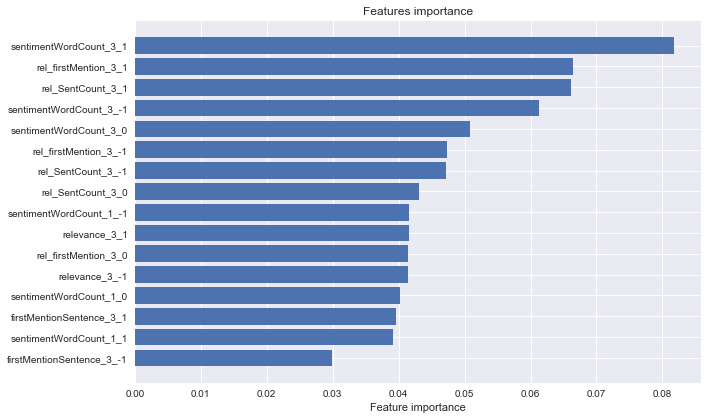

In [48]:
features_imp = pd.DataFrame()
features_imp['features'] = list(feature_columns)[:]
features_imp['importance'] = xgb_clf.feature_importances_
features_imp = features_imp.sort_values(by='importance', ascending=False).reset_index()

y = -np.arange(16)
plt.figure(figsize=(10,6))
plt.barh(y, features_imp.loc[:15,'importance'].values)
plt.yticks(y,(features_imp.loc[:15,'features']))
plt.xlabel('Feature importance')
plt.title('Features importance')
plt.tight_layout()
plt.savefig('features_importance.png')

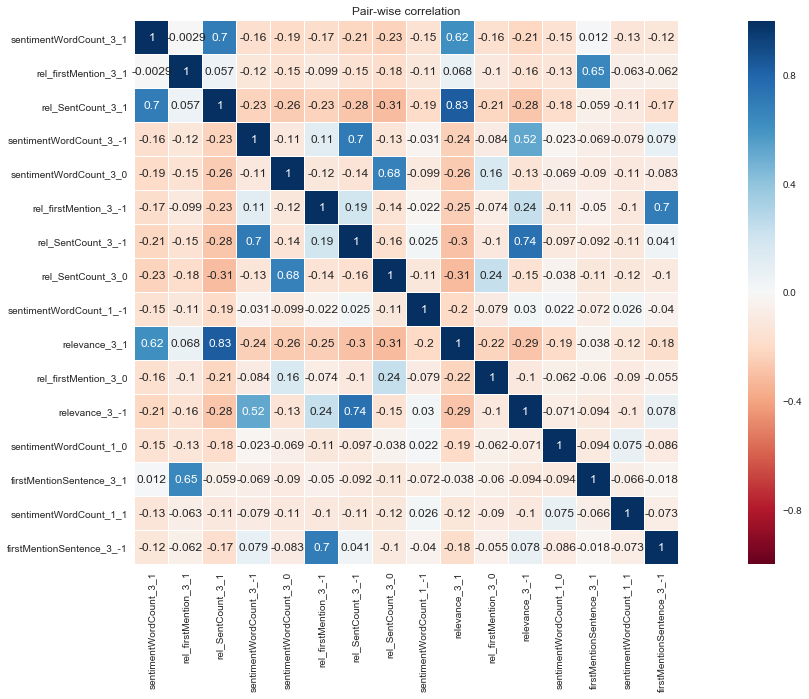

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# columns_corr = ['takeSequence', 'companyCount','marketCommentary','sentenceCount',\
#            'firstMentionSentence','relevance','sentimentClass','sentimentWordCount','noveltyCount24H',\
#            'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D','volumeCounts24H','volumeCounts3D','volumeCounts5D','volumeCounts7D','returnsOpenNextMktres10']
columns_corr = list(features_imp.loc[:15,'features'])
colormap = plt.cm.RdBu
plt.figure(figsize=(25,10))
sns.heatmap(market_news[columns_corr].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')
plt.savefig('correlation_matrix.png')

(31,)

### Saving the Prediction Accuracy for 1st to 10th day

In [167]:
accuracy = {}
X_train = market_train[feature_columns].values
X_test = market_test[feature_columns].values


In [168]:
for i in range(1, 11):    
    response = 'returnsOpenNextMktres' + str(i)
    
    up_train = market_train[response].map(lambda x: 0 if x<0 else 1).values
    up_test = market_test[response].map(lambda x: 0 if x<0 else 1).values
    Y_train = up_train
    Y_test = up_test
    
    xgb_clf = xgb.XGBClassifier(n_jobs=4,
                             objective='binary:logistic',
                            random_state=300)
    opt_params = {'n_estimators': 5000,
                  'max_depth': 8,
                  'subsample':0.7,
                  'colsample_bytree':0.8,
                  'min_child_weight': 10,
                  'gamma': 2,
                  'reg_lambda':1,
                   'reg_alpha':2,
                  'learning_rate':0.01}
    fit_params = {'early_stopping_rounds':100,
                  'eval_metric': 'auc',
                  'eval_set': [(X_train, Y_train), (X_test, Y_test)],
                  'verbose': 200
                  }
    xgb_clf.set_params(**opt_params)
    xgb_clf.fit(X_train, Y_train,**fit_params)
    
    train_acc = accuracy_score(Y_train, xgb_clf.predict(X_train))
    test_acc = accuracy_score(Y_test, xgb_clf.predict(X_test))
    
    print('Training accuracy: ', train_acc)
    print('Validation accuracy: ', test_acc)
    
    (TP,FP,TN,FN) = perf_measure(Y_train, xgb_clf.predict(X_train))
    #confusion_matrix(Y_train, lgb_clf.predict(X_train))
    TNR = TN/(TN+FP)
    TPR = TP/(TP+FN)
    print(TPR*100)
    print(TNR*100)
    
    accuracy[i] = [train_acc, test_acc, TPR, TNR]

[0]	validation_0-auc:0.605193	validation_1-auc:0.606959
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[96]	validation_0-auc:0.788453	validation_1-auc:0.791602

Training accuracy:  0.7619004506110316
Validation accuracy:  0.7701281209301291
76.66902701865416
75.68864540986708
[0]	validation_0-auc:0.602464	validation_1-auc:0.602933
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[29]	validation_0-auc:0.746909	validation_1-auc:0.752793

Training accuracy:  0.7185237160226268
Validation accuracy:  0.7273172523570467
72.3615401364762
71.32010833082568
[0]	validation_0-auc:0.598682	validation_1-auc:0.592884
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validat

In [71]:
import seaborn as sns; 
import matplotlib.pyplot as plt
sns.set()

In [72]:
# fmri = sns.load_dataset("fmri")

In [73]:
# ax = sns.lineplot(x="timepoint", y="signal", hue="event", style="event",markers=True, dashes=False, data=fmri)

AttributeError: module 'seaborn' has no attribute 'lineplot'

In [152]:
max(max(train_acc), max(test_acc))

0.7700390707614903

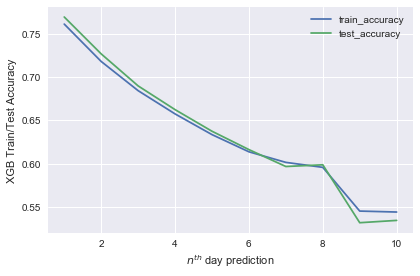

In [170]:
# Plot Train and Test accuracy
train_acc = [val[0] for key, val in accuracy.items()]
test_acc = [val[1] for key, val in accuracy.items()]
x_axis = [key for key, val in accuracy.items()]
plt.plot( x_axis, train_acc)
plt.plot( x_axis, test_acc)
plt.ylabel('XGB Train/Test Accuracy')
plt.xlabel('$n^{th}$ day prediction')
plt.legend(["train_accuracy", "test_accuracy"])
plt.tight_layout()
plt.savefig('train_test_accuracy.png')

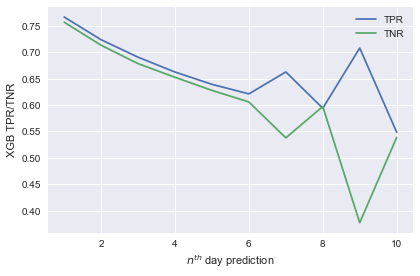

In [171]:
# Plot TPR and TNR accuracy
tpr_acc = [val[2] for key, val in accuracy.items()]
tnr_acc = [val[3] for key, val in accuracy.items()]
x_axis = [key for key, val in accuracy.items()]
plt.plot( x_axis, tpr_acc)
plt.plot( x_axis, tnr_acc)
plt.ylabel('XGB TPR/TNR')
plt.xlabel('$n^{th}$ day prediction')
plt.legend(["TPR", "TNR"])
plt.tight_layout()
plt.savefig('tpr_tnr.png')

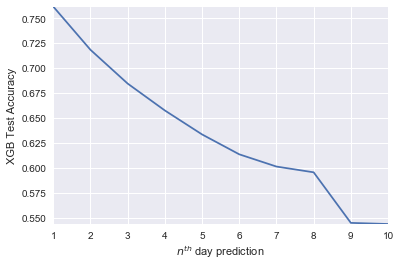

In [172]:
# Plot Test Accuracy
plotdata = []
plotdata.append([key for key, val in accuracy.items()])
plotdata.append([val[0] for key, val in accuracy.items()])
plt.plot(plotdata[0], plotdata[1])
plt.axis([min(plotdata[0]), max(plotdata[0]), min(plotdata[1]), max(plotdata[1])])
plt.ylabel('XGB Test Accuracy')
plt.xlabel('$n^{th}$ day prediction')
plt.show()

### Validation Curve

In [191]:
# Validation Curve
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

In [193]:
xgb_vc = xgb.XGBClassifier(n_jobs=4,
                         objective='binary:logistic',
                        random_state=300)

X_train = market_train[feature_columns].values
X_test = market_test[feature_columns].values

up_train = market_train['returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values
up_test = market_test['returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values
Y_train = up_train
Y_test = up_test


In [195]:
# n_estimators
n_estimators_range = [500, 1000, 2000, 5000]
train_scores, test_scores = validation_curve(xgb_vc, X_train, Y_train, param_name="n_estimators", param_range=n_estimators_range, cv=5)

plt.figure()
plt.semilogx(n_estimators_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(n_estimators_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for XGB')
plt.xlabel('n_estimators')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# 

KeyboardInterrupt: 

# For Viz

In [246]:
mm1 = news_data[(news_data['assetName'].str.contains("Facebook")) & (news_data['time'] == datetime.date(2012,8,16))].copy()
mm2 = market_data[(market_data['assetName'] == 'Facebook Inc') & (market_data['time'] == datetime.date(2012,8,16))].copy()
# mm1.groupby(['time','assetName'], as_index=False).mean()
# mm1['assetCodes'].map(lambda x: list(eval(x))[0])
# market_news[(market_news['rel_firstMention_3_1'] > 0) & (market_news['rel_firstMention_3_1'] < 1)]

In [247]:
mm1['returnsOpenPrevMktres1'] = float(mm2['returnsOpenPrevMktres1'])
mm1['returnsOpenPrevMktres10'] = float(mm2['returnsOpenPrevMktres10'])

In [252]:
# mm1

In [169]:
given_cols = ['time', 'headline', 'urgency', 'sentenceCount', 'wordCount', 'assetName', 'firstMentionSentence',
          'relevance', 'sentimentClass','sentimentWordCount','rel_firstMention', 'rel_SentCount',
              'returnsOpenPrevMktres1','returnsOpenPrevMktres10']
given_idx = [i for i, val in enumerate(given_cols)]
given_records = [] # Where the original record will go

In [ ]:
given_data = pd.DataFrame(given_records, columns = given_cols)

In [250]:
mm1['returnsOpenPrevMktres1_dir'] = mm1['returnsOpenPrevMktres1'].apply(lambda x: 0 if x<0 else 1)
mm1['returnsOpenPrevMktres10_dir'] = mm1['returnsOpenPrevMktres10'].apply(lambda x: 0 if x<0 else 1)

In [ ]:
range_sent = given_data['sentimentClass'].unique()
range_urg = given_data['urgency'].unique()
# print("Unique Sentiment Values : {}".format(range_sent))
# print("Unique Urgency Values:  {}".format(range_urg))

cols_filtered = ['rel_firstMention', 'rel_SentCount', 'relevance', 'firstMentionSentence', 
           'sentenceCount', 'sentimentWordCount', 'wordCount']
for i in range_sent:
    for j in range_urg:
        for col in cols_filtered:
            new_col = col + "_" + str(j) + '_' + str(i)
            given_data[new_col] = 0.0
            given_data.loc[((given_data['sentimentClass'] == i)  & (given_data['urgency'] == j)),new_col] = \
                given_data.loc[((given_data['sentimentClass'] == i)  & (given_data['urgency'] == j)),col]
given_data.drop(labels=cols_filtered + ['urgency','sentimentClass'], axis=1, inplace=True)
gc.collect()
print("Given data Shape : {}".format(given_data.shape))

In [255]:
req_feature_columns = [ 'returnsOpenPrevMktres1_dir', 'returnsOpenPrevMktres10_dir', 
                   'relevance_1_1', 'firstMentionSentence_1_1', 
        'sentimentWordCount_1_1', 
       'relevance_3_1', 'firstMentionSentence_3_1', 'sentimentWordCount_3_1',
       'relevance_1_0', 'firstMentionSentence_1_0', 
       'sentimentWordCount_1_0', 'relevance_3_0',
       'firstMentionSentence_3_0', 'sentimentWordCount_3_0', 
       'relevance_1_-1', 'firstMentionSentence_1_-1',
       'sentimentWordCount_1_-1',
       'relevance_3_-1', 
       'firstMentionSentence_3_-1', 
       'sentimentWordCount_3_-1', 
        'rel_SentCount_1_1', 'rel_SentCount_3_1', 'rel_firstMention_1_1', 'rel_firstMention_3_1', 
        'rel_firstMention_1_0', 'rel_SentCount_1_0', 'rel_firstMention_3_0', 'rel_firstMention_1_-1', 
        'rel_SentCount_3_0', 'rel_SentCount_1_-1', 'rel_firstMention_3_-1', 'rel_SentCount_3_-1']

In [262]:
given_X_train = mm1[req_feature_columns].values

In [263]:
given_Y_predict = loaded_model.predict(given_X_train)

In [264]:
given_Y_predict.shape

(38,)

In [267]:
given_X_train_mean = mm1.groupby(['time','assetName'], as_index=False).mean()[req_feature_columns].values

In [269]:
given_Y_predict_mean = loaded_model.predict(given_X_train_mean)

In [270]:
given_Y_predict_mean

array([1], dtype=int64)

## Model training PCA + NN

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
pca = PCA()
pca.fit(x_train)

In [ ]:
cum_variance = pca.explained_variance_ratio_.cumsum()
plt.title('Cumulative Explained Variance Vs Number of components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(0,100,5))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.plot(cum_variance)
plt.show()
comp = np.where(np.min(cum_variance[cum_variance > 0.98]) == cum_variance)
print("Number of components which are explaining atleast 98% variance : {}".format(comp[0][0]))
comp = np.where(np.min(cum_variance[cum_variance > 0.95]) == cum_variance)
print("Number of components which are explaining atleast 95% variance : {}".format(comp[0][0]))
comp = np.where(np.min(cum_variance[cum_variance > 0.90]) == cum_variance)
print("Number of components which are explaining atleast 90% variance : {}".format(comp[0][0]))
## 40 com

In [ ]:
#market_train[feature_columns] = market_train[feature_columns].fillna(0)
#print('scaling numerical columns')
#market_train[feature_columns] = scaler.fit_transform(market_train[feature_columns])

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)

pca = PCA(n_components=25)
pca.fit(x_train)
x_pca = pca.transform(x_train)

In [ ]:
# Train accuracy
mlp = MLPClassifier(hidden_layer_sizes=(50,))

mlp.fit(x_pca, Y_train)
Y_pred = mlp.predict(x_pca)
accuracy_score(Y_train, Y_pred)

In [ ]:
# Test accuracy
x_test = scaler.transform(X_test)
x_pca = pca.transform(x_test)
Y_pred = mlp.predict(x_pca)
accuracy_score(Y_test, Y_pred)

### Grid Search for hypertuning

In [ ]:
def get_best_model(X,Y):
    d = X.shape[1]
    hidden_layer = [(h,)*l for l in [1,2,3] for h in [d,d//2,d*2]]
    param_grid = {'hidden_layer_sizes': hidden_layer, \
                'learning_rate_init': [0.05, 0.1, 0.5], \
                'max_iter': [500,1000, 2000] }

    model = GridSearchCV(estimator = MLPClassifier(activation='relu', learning_rate='constant'), \
                        param_grid=param_grid, cv= 5)
    model.fit(X, Y)
    print(model.best_params_)
    estimator = MLPClassifier(activation='relu', learning_rate='constant', \
                                hidden_layer_sizes=model.best_params_['hidden_layer_sizes'], \
                                learning_rate_init=model.best_params_['learning_rate_init'], \
                                max_iter=model.best_params_['max_iter'])
    return estimator

In [ ]:
mlp_f = get_best_model(x_pca, Y_train)

In [ ]:
# Train accuracy with the hypertuned model
mlp_f.fit(x_pca, Y_train)
Y_pred = mlp.predict(x_pca)
accuracy_score(Y_train, Y_pred)

In [ ]:
# Test accuracy with hypertuned model
x_test = scaler.transform(X_test)
x_pca = pca.transform(x_test)
Y_pred = mlp_f.predict(x_pca)
accuracy_score(Y_test, Y_pred)

### Not good at choosing layers and neurons

#### Training, Test Accuracy with different future day prediction
    01 : 81.9, 81.6
    02 : 76.5, 76.4
    04 : 69.4, 69.3
    06 : 64.8, 64.6
    10 : 55, 54


#### PCA

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
chi2_selector = SelectKBest(chi2, k="all")
X_kbest = chi2_selector.fit_transform(x_train, Y_train)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization
from keras.losses import binary_crossentropy, mse

categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)

numerical_inputs = Input(shape=(11,), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='sigmoid')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=binary_crossentropy)


In [ ]:

colormap = plt.cm.RdBu
plt.figure(figsize=(50,20))
sns.heatmap(market_train[heat_col].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')

# Rough Work

In [ ]:
news_data[(news_data['assetName'] == "Cablevision Systems Corp") & (news_data['time'] == datetime.datetime.strptime('2010-01-01', "%Y-%m-%d").date())]

In [ ]:
news_group = news_data.groupby(['time', 'assetName'])

In [ ]:
news_group[]

In [ ]:
def unstack_asset_codes(news_train):
    codes = []
    indexes = []
    for i, values in news_train['assetCodes'].iteritems():
        explode = values.split(", ")
        codes.extend(explode)
        repeat_index = [int(i)]*len(explode)
        indexes.extend(repeat_index)
    index_df = pd.DataFrame({'news_index': indexes, 'assetCode': codes})
    del codes, indexes
    gc.collect()
    return index_df

In [ ]:
index_df = unstack_asset_codes(news_data)
index_df.head()

In [ ]:
def merge_news_on_index(news_train, index_df):
    news_train['news_index'] = news_train.index.copy()

    # Merge news on unstacked assets
    news_unstack = index_df.merge(news_train, how='left', on='news_index')
    news_unstack.drop(['news_index', 'assetCodes'], axis=1, inplace=True)
    return news_unstack

In [ ]:
news_unstack = merge_news_on_index(news_data, index_df)
del news_train, index_df
gc.collect()
news_unstack.head(3)

In [ ]:
print("Maddar")